In [83]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import trange
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

import brighteyes_ism.simulation.PSF_sim as sim
import brighteyes_ism.analysis.Graph_lib as gra
import brighteyes_ism.dataio.mcs as mcs

from s2ism import s2ism as s2
import s2ism.psf_estimator as est

For this notebook, an additional package is required for FLIM data analysis and visualization.

It can be installed from the following GitHub repository:
https://github.com/VicidominiLab/BrightEyes-Flim

In [2]:
import brighteyes_flim.flism as flim

# Data download

Experimental dataset can be downloaded from [https://doi.org/10.5281/zenodo.11284051](https://doi.org/10.5281/zenodo.11284051).

Here, we download and decompress the data into the Downloas folder.

In [3]:
import requests
from tqdm import tqdm, trange
from pathlib import Path
import os
import zipfile

def download(url, fname):
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(fname, 'wb') as file, tqdm(
            desc=fname,
            total=total,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
            
def extract(filename):
    dir_name = filename[:-4]
    os.mkdir(dir_name)
    with zipfile.ZipFile(filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting '):
            try:
                zf.extract(member, dir_name)
            except zipfile.error as e:
                pass

In [4]:
downloads_path = str(Path.home() / 'Downloads')

url_data = 'https://zenodo.org/records/11284051/files/h5_files_s2ism.zip'
name_data = 'h5_files_s2ism.zip'

filename = os.path.join(downloads_path, name_data)

In [5]:
if not os.path.isfile(filename):
    print('Downloading data:' + filename + '\n')
    download(url_data, filename)
else:
    print('File already downloaded.')

File already downloaded.


In [6]:
dir_name = filename[:-4]

if not os.path.exists(dir_name):
    print('Extracting compressed data:\n')
    extract(filename)

# Data loading

In [7]:
file = r'Lamina_tubulin_flim_data-10-04-2024-19-27-47.h5'

fullpath = os.path.join(dir_name, file)

data, meta = mcs.load(fullpath)

print('Loaded data: ' + file)

dset = np.squeeze(data)

del data

Loaded data: Lamina_tubulin_flim_data-10-04-2024-19-27-47.h5


In [8]:
data_extra, _ = mcs.load(fullpath, key="data_channels_extra")
laser = data_extra[:, :, :, :, :, 1].sum((0, 1, 2, 3)) * 1.
laser /= laser.max()

# IRF Loading

In [9]:
file_irf = r'IRF_for_lamina_tubulin_flim_data-10-04-2024-19-50-34.h5'
fullpath_irf = os.path.join(dir_name, file_irf)

data_irf, meta_irf = mcs.load(fullpath_irf)

print(f'Loaded IRF data: {file_irf}')

Loaded IRF data: IRF_for_lamina_tubulin_flim_data-10-04-2024-19-50-34.h5


We acquired the IRFs of our microscope measuring the scattering responde of a gold nanoparticle.
Since the spatial structure is of no interest, we sum over all the non relevant dimensions. The result is 2D: time and SPAD channel.

In [10]:
dset_irf = np.sum(data_irf, axis = (0, 1, 2, 3) ) * 1.
dset_irf /= dset_irf.max(-2)

del data_irf

In [11]:
data_extra_irf, _ = mcs.load(fullpath_irf, key="data_channels_extra")
laser_irf = data_extra_irf[:, :, :, :, :, 1].sum((0, 1, 2, 3)) * 1.
laser_irf /= laser_irf.max()

The data and IRF measurements have been acquired separately. Therefore, they are not necessarily synchronized in time.

We can use the laser trigger to move the two datasets to the same temporal reference frame.

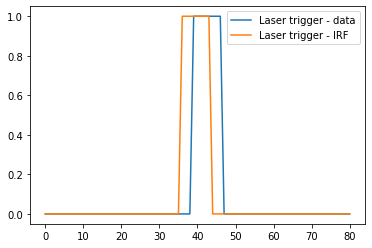

In [12]:
plt.figure()
plt.plot(laser, label = 'Laser trigger - data')
plt.plot(laser_irf, label = 'Laser trigger - IRF')
plt.legend()

In [13]:
dt = 0.297619 # DFD bin time, ns
dfd_freq = 1e3/(meta.nbin*dt) # MHz

print(f'Excitation frequency = {dfd_freq:.2f} MHz')

time = np.arange(dset_irf.shape[0]) * dt

Excitation frequency = 41.48 MHz


Text(0.5, 1.0, 'Impulse Response Functions')

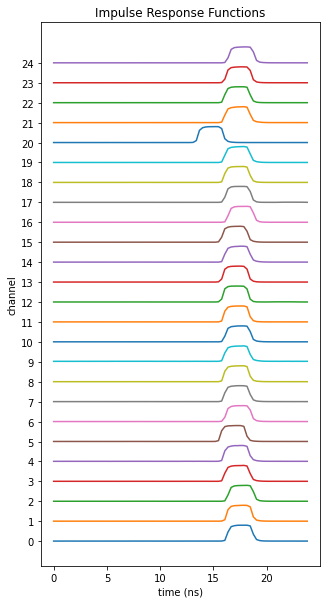

In [14]:
plt.figure(figsize = (5, 10))

for n in range(dset.shape[-1]):
    plt.plot(time, 0.8*dset_irf[:, n] + n)
    
plt.yticks(np.arange(25))
plt.xlabel('time (ns)')
plt.ylabel('channel')
plt.title('Impulse Response Functions')

We experimentally acquired the IRFs without spectral filters, because we worked in the Rayleigh scattering regime. Therefore, we need to remove spurious reflections from the data to produce close-to-ideal IRFs. We measure the center-of-mass of each IRF and we apply a window (2 ns) around it. The signal outside the windows is clipped to zero.

In [15]:
def centroid(data):
    x = np.arange(data.size)
    idx = np.sum(x*data)/data.sum()
    return idx

def clean_irf(irf, threshold = 0.3, window = 6):
    
    time = np.arange(irf.size)
    
    t_irf = np.where(irf>threshold, irf, 0)
    
    t0 = centroid(t_irf)
    
    indices = np.argwhere(np.logical_and(time > t0 - window, time < t0 + window))
    
    final_irf = np.zeros_like(irf)
    
    final_irf[indices] = irf[indices]
    
    return final_irf

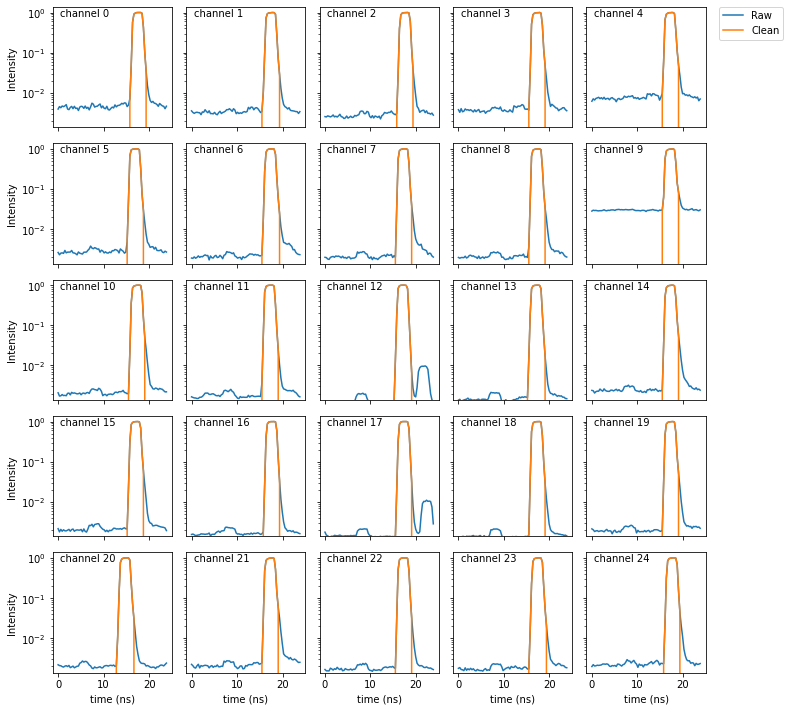

In [52]:
final_irf = np.empty_like(dset_irf)

fig, ax = plt.subplots(5,5, figsize = (10,10), sharex = True, sharey = True)

for n in range(dset_irf.shape[-1]):

    final_irf[:, n] = clean_irf(dset_irf[:, n], threshold = 0.3, window = 2/dt)
    
    idx = np.unravel_index(n, (5,5))
    
    l1, = ax[idx].semilogy(time, dset_irf[:, n])
    l2, = ax[idx].semilogy(time, final_irf[:, n])
    
    ax[idx].text(0.5, 0.8,f'channel {n}')
    
    if idx[0] == 4:
        ax[idx].set_xlabel('time (ns)')
    if idx[1] == 0:
        ax[idx].set_ylabel('Intensity')

fig.legend((l1, l2), ('Raw', 'Clean'), bbox_to_anchor=(1.1, 0.99))
fig.tight_layout()

# FLISM image reconstruction

## s$^2$ISM

We simulate the spatial PSFs of the system.

In [17]:
exPar = sim.simSettings()
exPar.na = 1.4   # numerical aperture
exPar.wl = 640   # excitation wavelength [nm]
exPar.gamma = 45  # parameter describing the light polarization
exPar.beta = 90  # parameter describing the light polarization
exPar.n = 1.5 # refractive index
exPar.mask_sampl = 100 # pupile plane sample points

emPar = exPar.copy()
emPar.wl = 660 # emission wavelength [nm]

grid = sim.GridParameters()
grid.Nz = 2 # number of axial planes
grid.pxsizex = meta.dx*1e3 # pixel size [nm]
grid.pxsizez = 720 # axial spacing [nm]
grid.pxpitch = 75e3 # pitch of the detector array [nm]
grid.pxdim = 50e3 # size of the pixels of the detector array [nm]
grid.N = 5 # numer of pixels per axis of the array

psf_spatial, _,_ = est.psf_estimator_from_data(dset.sum(-2), exPar, emPar, grid, z_out_of_focus = grid.pxsizez)

pxsizex       40.00
pxsizez       720.00
Nx            100.00
Nz            2.00
pxpitch       75000.00
pxdim         50000.00
pinhole_shape square
geometry      rect
N             5.00
M             455.00
rotation      2.72
mirroring     1.00
name          
shift         77.07
Calculating the PSFs stack from z = -720.0 nm to z = 0.0 nm:


100%|██████████| 2/2 [39:17<00:00, 1178.80s/it]


Out-of-focus PSFs


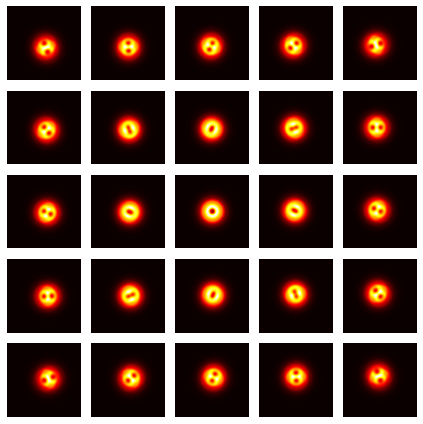

In [18]:
print('Out-of-focus PSFs')
fig_1 = gra.ShowDataset(psf_spatial[0])

In-focus PSFs


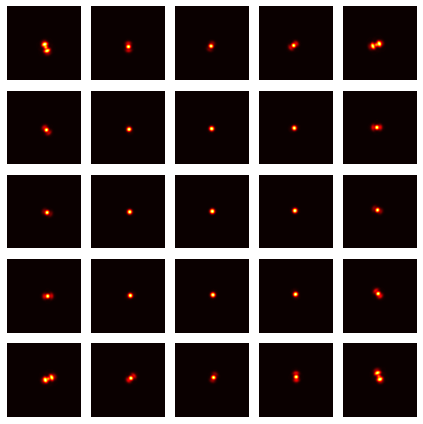

In [19]:
print('In-focus PSFs')
fig_2 = gra.ShowDataset(psf_spatial[1])

We merge the temporal IRFs with the spatial PSFs in a single 4D convolution kernel.

In [20]:
psf_irf = est.combine_psf_irf(psf_spatial, final_irf)

We launch the reconstruction. Since the raw data require a significant amount of memory, we split the reconstruction into multiple batches. The overlap should be a number of pixels much larger than the size of the PSF, to avoid stitching artefacts.

If CUDA is available, choose _process='gpu'_ to speed up the computation.

In [21]:
s2_rec = s2.batch_reconstruction(dset, psf_irf, batch_size = [301, 301], overlap = 40, max_iter = 5, process='cpu')

Batch 1/25


Progress: 6it [02:48, 28.01s/it]                       


Batch 2/25


Progress: 6it [02:49, 28.18s/it]                       


Batch 3/25


Progress: 6it [03:01, 30.28s/it]                       


Batch 4/25


Progress: 6it [03:02, 30.42s/it]                       


Batch 5/25


Progress: 6it [01:36, 16.14s/it]                       


Batch 6/25


Progress: 6it [03:13, 32.22s/it]                       


Batch 7/25


Progress: 6it [03:18, 33.07s/it]                       


Batch 8/25


Progress: 6it [03:02, 30.43s/it]                       


Batch 9/25


Progress: 6it [02:41, 26.86s/it]                       


Batch 10/25


Progress: 6it [01:38, 16.39s/it]                       


Batch 11/25


Progress: 6it [02:39, 26.58s/it]                       


Batch 12/25


Progress: 6it [03:05, 30.95s/it]                       


Batch 13/25


Progress: 6it [02:52, 28.75s/it]                       


Batch 14/25


Progress: 6it [02:48, 28.15s/it]                       


Batch 15/25


Progress: 6it [01:37, 16.33s/it]                       


Batch 16/25


Progress: 6it [02:59, 29.88s/it]                       


Batch 17/25


Progress: 6it [02:58, 29.72s/it]                       


Batch 18/25


Progress: 6it [02:52, 28.69s/it]                       


Batch 19/25


Progress: 6it [02:46, 27.71s/it]                       


Batch 20/25


Progress: 6it [01:37, 16.25s/it]                       


Batch 21/25


Progress: 6it [01:38, 16.35s/it]                       


Batch 22/25


Progress: 6it [01:39, 16.53s/it]                       


Batch 23/25


Progress: 6it [01:40, 16.68s/it]                       


Batch 24/25


Progress: 6it [01:39, 16.61s/it]                       


Batch 25/25


Progress: 6it [01:09, 11.54s/it]                       


In [93]:
s2_flism = s2_rec[1]

## Confocal

We measure the time delays between IRFs and align them.

In [81]:
nch = dset_irf.shape[-1]
time_delay = np.empty(nch)

irf_shifted = np.empty_like(dset_irf)

for i in range(dset_irf.shape[-1]):
    time_delay[i] = phase_cross_correlation(final_irf[:, 12], final_irf[:, i], upsample_factor=10, normalization=None)[0].item()
    irf_shifted[:, i] = shift(final_irf[:, i], time_delay[i], order = 1, mode='grid-wrap')

We define the equivalent IRF of the confocal system as the sum of the aligned IRFs weighted by the fingerprint.

In [79]:
fingerprint = dset.sum( (0,1,2) )
irf_sum = np.einsum('ij,j', irf_shifted, fingerprint)
irf_sum /= irf_sum.max()

Text(0.5, 1.0, 'Confocal IRF')

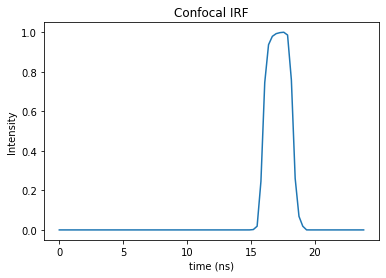

In [80]:
plt.figure()
plt.plot(time, irf_sum)
plt.xlabel('time (ns)')
plt.ylabel('Intensity')
plt.title('Confocal IRF')

We align also the decays of the raw dataset.

In [85]:
dset_shifted = np.empty_like(dset)

spatiotemporal_shift_vectors = np.zeros((dset.ndim - 1, nch))
spatiotemporal_shift_vectors[-1] = time_delay

print('Aligning fluorescence decays: \n')
for i in trange(nch):
    dset_shifted[..., i] = shift(dset[..., i], spatiotemporal_shift_vectors[:, i], order = 1, mode='grid-wrap')

dset_sum = dset_shifted.sum(-1)

Aligning fluorescence decays: 



100%|██████████| 25/25 [03:05<00:00,  7.40s/it]


Text(0.5, 1.0, 's$^2$ISM')

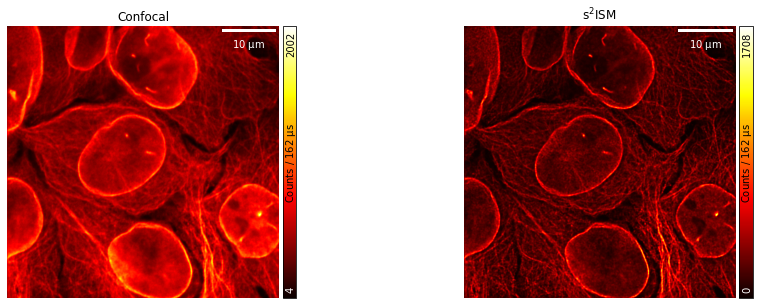

In [86]:
intensity_focus = s2_flism.sum(-1)
intensity_sum = dset_sum.sum(-1)

fig, ax = plt.subplots(1,2, figsize = (15,5))

gra.ShowImg(intensity_sum, meta.dx, meta.pxdwelltime, fig = fig, ax = ax[0])
ax[0].set_title('Confocal')
gra.ShowImg(intensity_focus, meta.dx, meta.pxdwelltime, fig = fig, ax = ax[1])
ax[1].set_title(r's$^2$ISM')

# Phasor analysis

We calculate the phasor of the data pixel-by-pixel.

In [87]:
phasor_sum = flim.phasor(dset_sum)
phasor_irf_sum = flim.phasor(irf_sum)

phasor_f = flim.phasor(s2_flism)

We correct phasor with respect to laser reference.

We also calibrate the confocal FLIM phasors with the IRF.

In [88]:
correction_phasor = flim.correction_phasor(laser, laser_irf)

phasor_sum = phasor_sum * correction_phasor / phasor_irf_sum

phasor_f = -phasor_f * correction_phasor

We calculate the lifetime using the modulation of the phasors.

In [90]:
lifetime_sum = flim.calculate_tau_m(phasor_sum, dfd_freq = dfd_freq) * 1e3 # ns

lifetime_f = flim.calculate_tau_m(phasor_f, dfd_freq = dfd_freq) * 1e3 # ns

To discard noisy pixels, we threshold the phasors at the 5% of the peak intensity.

In [91]:
threshold = 0.05

thresholded_phasor_sum = flim.threshold_phasor(intensity_sum, phasor_sum, threshold)

thresholded_phasor_f = flim.threshold_phasor(intensity_focus, phasor_f, threshold)

thresholded_tau_sum = flim.calculate_tau_m(thresholded_phasor_sum, dfd_freq=dfd_freq) * 1e3
thresholded_tau_f = flim.calculate_tau_m(thresholded_phasor_f, dfd_freq=dfd_freq) * 1e3

thresholded_tau_sum = thresholded_tau_sum[np.isfinite(thresholded_tau_sum)]
thresholded_tau_f = thresholded_tau_f[np.isfinite(thresholded_tau_f)]

We plot and compare the results.

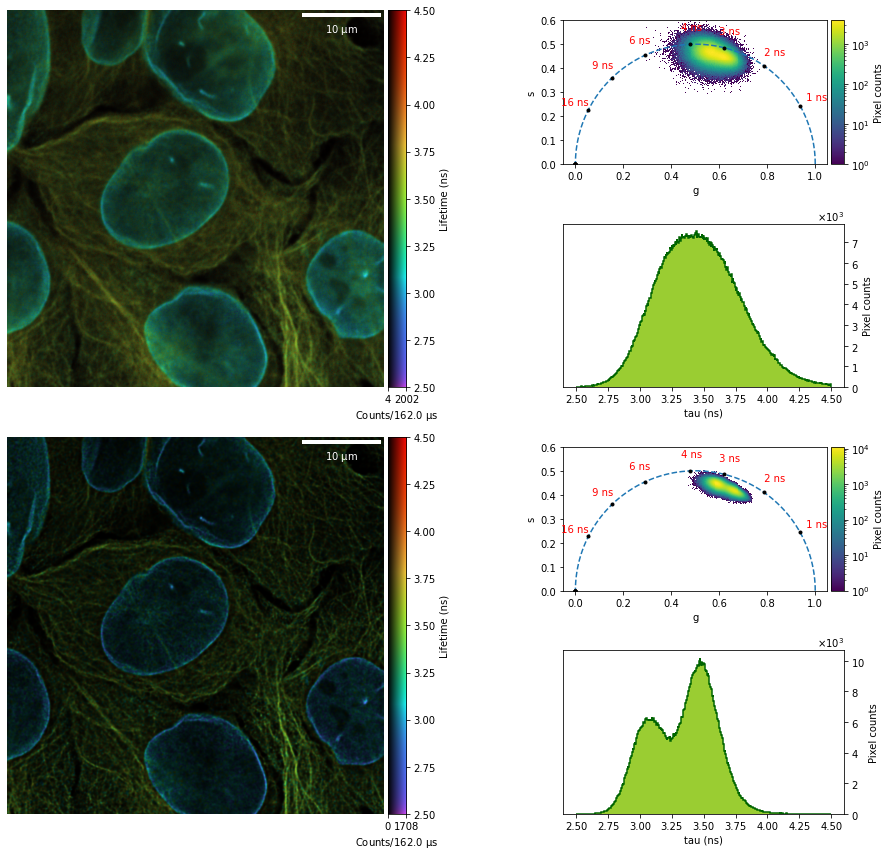

In [92]:
from matplotlib.ticker import ScalarFormatter

crop = 30
cmap = 'turbo'

upper_bound = 4.5
lower_bound = 2.5

bin_plot = 500

fig = plt.figure(figsize = (18, 12))
gs = fig.add_gridspec(4, 4)

ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])

gra.show_flim(intensity_sum[crop:-crop, crop:-crop], lifetime_sum[crop:-crop, crop:-crop], meta.dx, meta.pxdwelltime, lifetime_bounds = [lower_bound,upper_bound], fig = fig, ax = ax1, colormap=cmap)
gra.show_flim(intensity_focus[crop:-crop, crop:-crop], lifetime_f[crop:-crop, crop:-crop], meta.dx, meta.pxdwelltime, lifetime_bounds = [lower_bound,upper_bound], fig = fig, ax = ax2, colormap=cmap)

ax3 = fig.add_subplot(gs[0, 2:3])
ax4 = fig.add_subplot(gs[1, 2:3])

flim.plot_phasor(thresholded_phasor_sum, quadrant='first', bins_2dplot = bin_plot, cmap='viridis', dfd_freq = dfd_freq*1e6,  fig = fig, ax = ax3)
ax4.hist(thresholded_tau_sum, bins = 500, range=(lower_bound, upper_bound), histtype='step', fill=True, fc='yellowgreen', edgecolor='darkgreen', linewidth=1.5)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_xlabel('tau (ns)')
ax4.set_ylabel('Pixel counts')
sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((3,3))
ax4.yaxis.set_major_formatter(sf)

ax5 = fig.add_subplot(gs[2, 2:3])
ax6 = fig.add_subplot(gs[3, 2:3])

flim.plot_phasor(thresholded_phasor_f, quadrant='first', bins_2dplot = bin_plot, cmap='viridis',  dfd_freq = dfd_freq*1e6,  fig = fig, ax = ax5)
ax6.hist(thresholded_tau_f, bins = 500, range=(lower_bound, upper_bound), histtype='step', fill=True, fc='yellowgreen', edgecolor='darkgreen', linewidth=1.5)
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax6.set_xlabel('tau (ns)')
ax6.set_ylabel('Pixel counts')
ax6.yaxis.set_major_formatter(sf)

fig.tight_layout()